In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib
import time
from lb2jpsil import fit_utils
from scipy import optimize, integrate
from sklearn import metrics

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'

plot_directory = (
    repo_dir + 'plots/'
    + 'invariant_mass_fits/'
)

state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Monte Carlo data

In [10]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

del(df_reco, df_truth)

## Prefilters

In [11]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [12]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [13]:
pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [14]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

df_mc[pre_selection_cuts]

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
22,0.7534,-0.2931,-1.211400,-38.645302,-105.471802,7776.826172,-649.429993,-1605.150024,113660.250000,-26.830000,...,-212.451355,21583.396484,-1120.001343,617.919861,42654.800781,-1715.901855,-2823.659180,61855.921875,T,557
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,333.910950,9501.028320,2120.855713,-512.437805,21471.363281,1422.310791,630.151917,63757.222656,T,619
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,253.818954,8944.032227,-92.296303,549.597534,4568.076172,-3728.750244,-864.499451,124946.085938,T,798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366319,0.5569,0.0628,57.432899,120.215797,-371.462097,7690.597168,355.570007,-1350.780029,26500.039062,109.430000,...,-77.371887,2933.286621,-351.905731,-1046.896729,16813.599609,-2127.755615,2085.741699,38545.183594,T,8919802
366327,0.1985,-0.1576,-19.471500,-207.092300,-37.506302,6777.450195,-2266.669922,-458.640015,76301.921875,-294.079987,...,11.039152,7001.399414,-21.106155,590.822510,6469.677734,-4038.527100,-3013.788818,66493.257812,T,8920122
366331,0.8633,0.1466,-68.771400,-63.068901,-245.641098,6745.173828,-477.579987,-2102.550049,59762.968750,-199.369995,...,-527.474792,12987.607422,-1450.088257,-2851.202637,36621.058594,-248.967667,760.289551,5327.538574,T,8920230


# Run 2 data

In [15]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [16]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [17]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts

df_data[data_cuts]

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,-388.787109,-100.817314,6799.227051,-793.328735,54.095398,4428.873047,552.359741,-1187.884155,58499.570312,T
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-29.898186,-330.129730,4088.551514,-335.475464,856.159424,4723.041016,-2293.340088,-2661.276123,15929.165039,T
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,-239.040604,-38.133430,10148.586914,-1010.378479,-945.691162,13932.727539,2256.578613,-1760.062866,39286.671875,T
5,0.821056,-0.219265,-89.911835,-262.684479,-232.751587,8022.415527,0.8212,-0.2194,-89.908501,-670.206116,...,-455.008301,-448.525665,10629.112305,2688.982910,-2436.051758,68639.320312,-176.048676,688.883972,15541.456055,T
6,0.773095,-0.056306,114.457909,-383.886292,302.193207,6857.658691,0.7732,-0.0568,114.455597,-1560.964966,...,-101.245789,229.356186,3500.239014,-637.099548,2175.897949,8320.958984,307.778656,3687.872803,36119.546875,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650390,0.902737,0.043525,-5.716372,120.674232,-94.754593,6416.662598,0.9028,0.0432,-5.717900,1240.427734,...,67.786087,-44.520172,6007.832520,855.823669,-564.133362,9873.986328,-420.962463,2439.625244,12783.924805,T
43650395,0.491198,0.347749,-39.003174,462.251770,106.401283,7872.058594,0.4908,0.3479,-39.000198,1023.878113,...,183.017120,60.335880,2650.239258,-2629.139404,1626.435181,22277.369141,576.743408,-467.543671,8074.763184,T
43650396,1.011017,0.623186,1.597238,-146.384171,-16.609854,6533.204590,1.0110,0.6232,1.597100,-2191.683594,...,-330.747620,-30.148846,11230.413086,-477.367584,-706.816711,14534.184570,956.069763,2457.437988,75668.367188,T
43650398,0.675144,0.062440,29.156973,-22.783791,-140.079666,6325.636230,0.6752,0.0621,29.155399,-467.119171,...,72.710815,-140.158264,9041.322266,240.137115,-905.123169,12313.659180,-1580.417358,1636.189941,12926.920898,T


# Further data manipulation
## Add derived variables

In [18]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [19]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

## Drop based on prefilters

In [20]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

# HBDT

In [21]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [22]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [23]:
tick = time.perf_counter()
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"MC events predicted in {(tock - tick):0.4f} seconds.")

MC events predicted in 4.5778 seconds.


In [24]:
tick = time.perf_counter()
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"Data events predicted in {(tock - tick)/60:0.4f} minutes.")

Data events predicted in 6.1248 minutes.


In [25]:
df_mc['HBDT'] = mc_predicted
df_data['HBDT'] = data_predicted

In [26]:
del(mc_predicted, data_predicted)

## Remove events not passing the threshold

In [27]:
mc_pass_threshold = df_mc['HBDT'] > hard_threshold
data_pass_threshold = df_data['HBDT'] > hard_threshold

In [28]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)
df_data.drop(df_data[~data_pass_threshold].index, inplace=True)

## Remove events outside of the relevant mass windows

In [29]:
lower_limit_mass_Lb = 5000
upper_limit_mass_Lb = 6200

mc_Lb_invmass_cut = (
    (df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass_Lb)
    & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass_Lb)
)
data_Lb_invmass_cut = (
    (df_data['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass_Lb)
    & (df_data['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass_Lb)
)

In [30]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)
df_data.drop(df_data[~data_Lb_invmass_cut].index, inplace=True)

In [31]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.993490
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,T,619,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.995001
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,T,798,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.988892
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,T,1391,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
71,1.8416,-1.3280,21.833700,628.105896,-929.930481,7475.404785,3879.139893,-5898.799805,47200.421875,1059.250000,...,T,1897,5397.982422,6764.600098,6947.719238,1786.030396,1679.542480,1734.952637,6626.127441,0.997901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,T,8918751,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714
366291,0.2523,0.1334,-17.926600,-817.936401,-140.679001,6026.893066,-3532.949951,-677.299988,26030.919922,-342.480011,...,T,8919168,4604.340332,3631.394287,3332.437744,658.917603,412.858398,420.148010,6347.766113,0.992345
366313,0.4253,-0.0151,-0.922200,-159.258698,-53.847301,5842.161133,-2971.840088,-964.760010,105195.726562,-334.529999,...,T,8919632,4219.451660,3628.397949,3111.473877,156.685303,316.524811,366.231476,3196.120117,0.996885


In [32]:
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1243,0.570611,-0.048790,9.819603,-219.870300,-23.170826,6890.049316,0.5706,-0.0484,9.826700,-2135.995850,...,43281.066406,T,2118.871582,2296.816406,2250.925537,25.952250,128.293900,133.510849,1713.736938,0.991741
3224,1.287199,-0.047269,-13.550518,386.773163,260.747986,7545.715332,1.2871,-0.0472,-13.549400,2982.429932,...,66933.320312,T,3160.910889,2734.306152,2800.330078,681.059753,625.595215,723.562500,1597.382690,0.989822
5210,2.763927,-7.402781,28.077650,100.065308,-433.183167,7486.174805,2.7639,-7.4027,28.076799,617.860535,...,154809.203125,T,1960.515381,1419.280762,1433.296021,511.387817,450.912750,458.017365,16301.877930,0.990245
6626,0.139786,-0.059579,108.011452,-181.123703,-63.406746,7571.194824,0.1395,-0.0594,108.017700,-1520.058838,...,88736.515625,T,1320.226440,1446.456177,1548.127197,268.756439,260.548370,280.499908,7409.558594,0.989829
8572,1.059898,-0.769249,65.935455,190.492157,-194.708862,7476.943848,1.0599,-0.7692,65.934799,1988.378540,...,60940.515625,T,2134.475342,2105.480957,1894.416626,632.940308,622.114441,538.227722,6145.642090,0.996070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43640202,0.606850,-0.255569,3.714975,-42.871368,-136.398880,6625.701660,0.6068,-0.2556,3.715600,-704.583679,...,49504.613281,T,1902.609863,1317.207764,1112.647095,303.777618,208.493118,181.885315,4554.110352,0.991437
43641335,1.592275,0.470475,40.528099,844.270691,408.556732,7128.458008,1.5923,0.4705,40.528198,8160.525879,...,22930.691406,T,7166.815430,5513.578125,5487.751465,1606.892700,1651.535400,1634.031738,2975.259766,0.997649
43643898,0.661234,-0.403287,47.950920,46.069107,134.737579,7240.625000,0.6633,-0.4017,47.922600,507.450500,...,113621.703125,T,1201.043457,1601.999023,979.264160,197.984650,190.510666,183.268936,3910.110596,0.990513
43644236,-0.706107,-1.116585,-19.095575,-598.051270,-748.757507,6235.612305,-0.7061,-1.1166,-19.095600,-5272.707520,...,7243.077148,T,6555.232422,5079.992676,5601.033691,1301.919434,1350.152344,1419.455200,7243.634766,0.996143


# Invariant mass fits

In [33]:
## Takes as input a hexstring (doesn't care if with or without the leading hash)
## and an alpha value. Yields a tuple for matplotlib color definition
def hex_to_rgba(hexstring, alpha):
    if hexstring[0] == '#':
        hexstring = hexstring[1:]
    
    #return tuple(int(hexstring[i:i+2], 16) for i in (0, 2, 4))
    return list(int(hexstring[i:i+2], 16)/255 for i in (0, 2, 4)) + [alpha]

In [34]:
plum = '#6e304b'
apricot = '#e2ae6c'
lightplum = '#a37c82'

In [35]:
lambdab_pdg_mass = 5620.2

In [36]:
## Almost zero, but not quite
epsilon = 1e-15

In [37]:
## Double crystal ball parameter dictionary
sig_func = {
     'param_names' : [r'S'  , r'mu' , r'sigma', r'alpha_1', r'n_1', r'alpha_2', r'n_2'],
     'p0'          : [6e4   , 5618   ,  35      , 0.7        ,  3.7  , 0.7        ,    3.7],
     'lb'          : [1e1   , 5000   ,   1      , 0.1        ,  1.5  , 0.1        ,    1.5],
     'ub'          : [1e6   , 6250   , 200      , 5          ,   10  , 5          ,     10]
}

In [38]:
## Dictionary variant for the constrained sig+bkg fit
sig_func_constrained = {
     'param_names' : [ r'S', r'sigma' ],
     'p0'          : [  200,    35    ],
     'lb'          : [    0,     1    ],
     'ub'          : [  1e9,   200    ]
}

In [39]:
## Turn-on exponential dictionary
bkg_func = {
    'param_names' : [r'C',    r'a'],
    'p0' :          [0.09,    0.0008 ],
    'lb' :          [epsilon, epsilon],
    'ub' :          [1e9,     1      ]
}

## $J/\psi \Lambda^0$

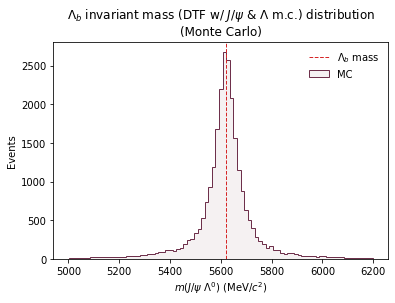

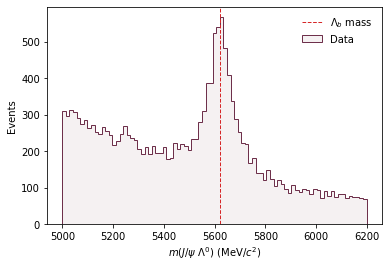

In [40]:
inv_mass_variable = 'DTF_FixJPsiLambda_Lb_M'
inv_mass_variable_title = '$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)'
bin_number = 85
basic_filename = 'lambdab_after_hard_hist'

plot_filename = 'MC_' + basic_filename

MC_events, MC_bins, MC_patches = plt.hist(
    df_mc.loc[:, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, label='MC')

if show_grid:
    plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

plot_filename = 'Data_' + basic_filename

data_events, data_bins, data_patches = plt.hist(
    df_data.loc[:, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, label='Data')

if show_grid:
    plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')

if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Real data)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

### Simulation

In [41]:
MC_bin_midpoints = (MC_bins[1:] + MC_bins[:-1]) / 2

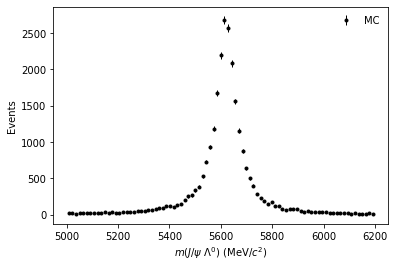

In [42]:
basic_filename = 'lambdab_after_hard_errorbar'
plot_filename = 'MC_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_color = 'black'
    fit_linestyle = '--'
    fit_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_color = 'tab:orange'
    fit_linestyle = None
    fit_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='MC')

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [43]:
MC_param_best, MC_param_covmatrix = optimize.curve_fit(
    f=fit_utils.crystal_ball_double_norm,
    xdata=MC_bin_midpoints,
    ydata=MC_events,
    p0=sig_func['p0'],
    sigma=np.sqrt(MC_events),
    bounds=(
        sig_func['lb'],
        sig_func['ub']
    )
)

In [44]:
MC_param_names = sig_func['param_names']
MC_param_error = np.sqrt(np.diag(MC_param_covmatrix))
for name, best, error in zip(MC_param_names, MC_param_best, MC_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 359165.0246827129 	+-	 2798.4151298756024
mu :		 5620.120081903303 	+-	 0.5457066113321152
sigma :		 36.7964654660692 	+-	 0.9436502050908451
alpha_1 :		 0.98488162864543 	+-	 0.034692619850138974
n_1 :		 2.435191077675031 	+-	 0.11244743007421716
alpha_2 :		 0.9952351265107937 	+-	 0.03537250458756902
n_2 :		 2.708448374249193 	+-	 0.13888393615803588


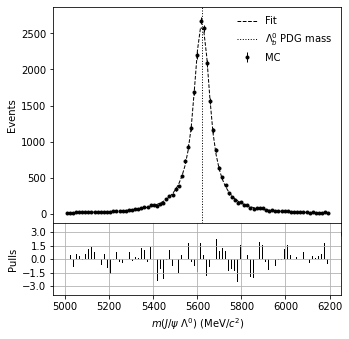

In [45]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'MC_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_color = 'black'
    fit_linestyle = '--'
    fit_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_color = 'tab:orange'
    fit_linestyle = None
    fit_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='MC')

plt.plot(MC_bin_midpoints,
         fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best),
         color=fit_color, linestyle=fit_linestyle, linewidth=fit_line_width,
         label='Fit')

plt.axvline(lambdab_pdg_mass, linestyle='dotted', color=lambda_pdg_color, linewidth=1, label='$\Lambda_b^0$ PDG mass')

if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=MC_bin_midpoints,
        height=(MC_events - fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best))/np.sqrt(MC_events),
        width=4,
        color=pull_color)
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [46]:
(
    _,
    mu_constr,
    _,
    alpha_1_constr,
    n_1_constr,
    alpha_2_constr,
    n_2_constr
) = MC_param_best

### Run 2 data

In [47]:
data_bin_midpoints = (data_bins[1:] + data_bins[:-1]) / 2

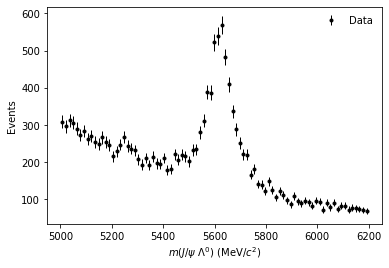

In [48]:
basic_filename = 'lambdab_after_soft_errorbar'
plot_filename = 'data_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_sig_color = 'black'
    fit_sig_linestyle = '--'
    fit_sig_line_width = 1.
    fit_bkg_color = 'black'
    fit_bkg_linestyle = '-.'
    fit_bkg_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_sig_color = 'tab:orange'
    fit_sig_linestyle = None
    fit_sig_line_width = None
    fit_bkg_color = 'tab:green'
    fit_bkg_linestyle = None
    fit_bkg_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='Data')

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [49]:
## This is the complete fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters (to MC fit results) apart from normalization S.
## 2. An exponential with free parameters C (normalization) and a (coefficient, as in exp[-a*x])
def sig_bkg_fit_function(x, S, sigma, C, a):
    ## Fixed parameters
    mu = mu_constr
    alpha1 = alpha_1_constr
    n1 = n_1_constr
    alpha2 = alpha_2_constr
    n2 = n_2_constr
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.exp(x, C, a)
    
    return signal + background

In [50]:
data_param_best, data_param_covmatrix = optimize.curve_fit(
    f=sig_bkg_fit_function,
    xdata=data_bin_midpoints,
    ydata=data_events,
    p0=sig_func_constrained['p0'] + bkg_func['p0'],
    sigma=np.sqrt(data_events),
    bounds=(
        sig_func_constrained['lb'] + bkg_func['lb'],
        sig_func_constrained['ub'] + bkg_func['ub']
    )
)

In [51]:
data_param_names = sig_func_constrained['param_names'] + bkg_func['param_names']
data_param_error = np.sqrt(np.diag(data_param_covmatrix))
for name, best, error in zip(data_param_names, data_param_best, data_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 64339.82721533367 	+-	 1896.3060427656706
sigma :		 41.291162117898125 	+-	 1.63782515456672
C :		 239847.90769838673 	+-	 37824.617973925226
a :		 0.0013317577917367257 	+-	 2.954619276754938e-05


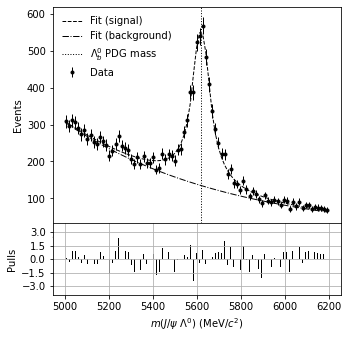

In [52]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'data_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_sig_color = 'black'
    fit_sig_linestyle = '--'
    fit_sig_line_width = 1.
    fit_bkg_color = 'black'
    fit_bkg_linestyle = '-.'
    fit_bkg_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_sig_color = 'tab:orange'
    fit_sig_linestyle = None
    fit_sig_line_width = None
    fit_bkg_color = 'tab:green'
    fit_bkg_linestyle = None
    fit_bkg_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='Data')

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color=fit_sig_color, linestyle=fit_sig_linestyle, linewidth=fit_sig_line_width,
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.exp(data_bin_midpoints, *data_param_best[2:]),
         color=fit_bkg_color, linestyle=fit_bkg_linestyle, linewidth=fit_bkg_line_width,
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='dotted', color=lambda_pdg_color, linewidth=1, label='$\Lambda_b^0$ PDG mass')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(loc='upper left', frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color=pull_color)
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [53]:
S, sigma, C, a = data_param_best

lower_integration_limit = mu_constr - 3 * sigma
upper_integration_limit = mu_constr + 3 * sigma

print("Integration interval:", ('{0:.5g}'. format(lower_integration_limit), '{0:.5g}'. format(upper_integration_limit)))

Integration interval: ('5496.2', '5744')


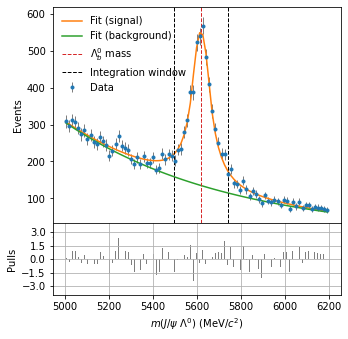

In [54]:
basic_filename = 'lambdab_hard_fit_window'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label='Data')

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.exp(data_bin_midpoints, *data_param_best[2:]),
         color='tab:green',
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b^0$ mass')
plt.axvline(lower_integration_limit, linestyle='--', color='k', linewidth=1)
plt.axvline(upper_integration_limit, linestyle='--', color='k', linewidth=1, label='Integration window')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [55]:
integration_window = (data_bin_midpoints >= lower_integration_limit) & (data_bin_midpoints <= upper_integration_limit)

s = sum(fit_utils.crystal_ball_double_norm(
    data_bin_midpoints[integration_window],
    S, mu_constr, sigma, alpha_1_constr, n_1_constr, alpha_2_constr, n_2_constr
))
b = sum(fit_utils.exp(data_bin_midpoints[integration_window], C, a))

print('Hard threshold:', hard_threshold)
print("s =", s, "\nb =", b)
print("Signal signifance:\t\t", s/np.sqrt(s+b))
print("Signal-to-background ratio:\t", s/b)
print("Signal purity:\t\t\t", s/(s+b))

Hard threshold: 0.985
s = 3572.658363342285 
b = 2433.6147689819336
Signal signifance:		 46.09872881984098
Signal-to-background ratio:	 1.4680459737827993
Signal purity:			 0.5948211619140588
